(genai-02-mm-llm)=
# Model monitoring using LLM

Maintaining the performance of machine learning models in production is essential.<br>
Model monitoring tracks key metrics like accuracy, latency, and resource usage, to identify issues such as data drift and model decay.<br>
Recently, large language models (LLMs) have been used as evaluators, offering nuanced feedback on model outputs. 

This notebook guides you through setting up an effective model monitoring system that leverages LLMs to maintain high standards for deployed models.<br>
It demonstrates how to prepare and evaluate a good prompt for the LLM judge, deploy model monitoring applications, 
assess the performance of a pre-trained model, fine-tune it using the ORPO technique on the supplied dataset, and finally, show the monitoring results for the fine-tuned model.

**Tutorial steps**
- [Setup](#setup)
- [Preparing the LLM as a judge](#preparing-the-llm-as-a-Judge)
- [Model monitoring](#model-monitoring)
- [Fine-tuning the model with ORPO ](#fine-tuning-the-model-with-orpo)
- [Check the performance of the fine-tuned model](#check-the-performance-of-the-fine-tuned-model)

## Setup

In [ ]:
%pip install -U datasets trl peft bitsandbytes sentencepiece openai

Get a Hugging-Face token from Hugging Face and OpenAI credentials from [Platform McKinsey](https://platform.mckinsey.com/)

In [1]:
openai_base_url = ""
openai_api_key = ""
hugging_face_token = ""

In [2]:
from datasets import load_dataset
from genai_monit_src.llm_as_a_judge import OpenAIJudge
import os
import pandas as pd
from tqdm.notebook import tqdm
import mlrun

os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["OPENAI_BASE_URL"] = openai_base_url
os.environ["HF_TOKEN"] = hugging_face_token

In [3]:
# Create the project:
project = mlrun.get_or_create_project(
    "tutorial",
    parameters={
        "default_image": "gcr.io/iguazio/llm-serving:1.7.0",
    },
    context="./genai_monit_src",
)

> 2024-09-17 11:36:45,712 [info] Project loaded successfully: {"project_name":"tutorial"}


In [7]:
# Deploy all the real-time monitoring functions:
project.set_model_monitoring_credentials(
    os.environ["V3IO_ACCESS_KEY"],
    "v3io",
    "v3io",
    "v3io",
)
project.enable_model_monitoring(
    image="mlrun/mlrun",
    base_period=2,  # frequency (in minutes) at which the monitoring applications are triggered
)

### Load the banking dataset

This example uses a small dataset to teach the model to answer only banking related questions. <br>
The dataset includes a prompt, an accepted answer, and a rejected answer, on the topic of banking. <br>
The dataset contains guardrails that prompt, in addition to the banking related prompts, to teach the model not to answer un-related questions. <br>
This dataset is also used later to train the model using ORPO.

In [4]:
# From hugging face hub:
dataset_name = "mlrun/banking-orpo"
dataset = load_dataset(dataset_name, split="train")
dataset = dataset.shuffle(seed=42)

Take a look at the dataset:

In [5]:
pd.set_option("display.max_colwidth", None)
df = dataset.to_pandas()
df.head()

,prompt,rejected,score,chosen
0,Which animal is known for its ability to swim against strong ocean currents?,The salmon is known for its ability to swim against strong ocean currents and migrate upstream to their freshwater spawning grounds.,0,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
1,How does a credit card work?,A credit card makes money grow in a magic pot each time you swipe it.,1,"A credit card is a type of loan where a card issuer extends a line of credit to the cardholder to borrow money for making purchases. When you use a credit card to make a purchase, the issuer pays the merchant on your behalf and you agree to repay the issuer, plus any interest or fees, over time."
2,In what year did the Mongol warrior Genghis Khan die?,"Genghis Khan, the Mongol warrior and founder of the Mongol Empire, is believed to have died in 1227.",0,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
3,What is the largest species of salamander?,"The Chinese giant salamander is considered the largest species of salamander, with adults reaching lengths of up to 5 feet",0,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
4,How to make a budget-friendly 30-minute dinner?,"Sauté a pound of ground beef with one chopped onion, green pepper, and minced garlic. Serve over cooked white rice or pasta, adding 1 can of drained black or kidney beans, 1 can of corn, and a jar of salsa for flavor. Top with shredded cheese or sour cream, if desired.",0,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"


## Prepare the LLM as a judge 

Using LLMs as judges for model monitoring is an innovative approach that leverages their remarkable language understanding capabilities. <br>
LLMs can serve as reference models, or assist in assessing the quality, factuality, and potential biases, in the outputs of monitored models.<br>
This approach offers scalability, consistency, adaptability, and cost-effectiveness, and enables robust and continuous monitoring of language models.

First, create a function to evaluate the LLM-judge's accuracy:

In [6]:
def compute_accuracy(col1, col2):
    # Calculate the number of matching values
    matching_values = sum(col1 == col2)

    # Calculate the total number of values
    total_values = len(col1)

    # Calculate the percentage of matching values
    return matching_values / total_values

Now, prepare the dataset for evaluation.
Take 10% of the data and split it into two:
- The first portion contains questions and answers as expected, meaning that the answers are taken from the **chosen** column.
- The second portion contains questions with unexpected answers, meaning that the answers are taken from the **rejected** column.

In [7]:
# Take only 10% of the data:
orpo_dataset = dataset.to_pandas().sample(frac=0.1, random_state=42, ignore_index=True)
middle_index = len(orpo_dataset) // 2

# Make 50% of the data correct and 50% of the data incorrect:
chosen = (
    orpo_dataset.iloc[:middle_index]
    .rename(columns={"prompt": "question", "chosen": "answer"})
    .drop("rejected", axis=1)
)
rejected = (
    orpo_dataset.iloc[middle_index:]
    .rename(columns={"prompt": "question", "rejected": "answer"})
    .drop("chosen", axis=1)
)

chosen["score"] = 1
rejected["score"] = 0

evaluate_dataset = pd.concat([chosen, rejected])
labels = evaluate_dataset["score"]

And here is the eval set:

In [8]:
evaluate_dataset.head()

,question,score,answer
0,What are the key challenges facing the education system today?,1,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
1,What is an artificial neural network?,1,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
2,Which animal is known for its ability to produce venom that affects the muscular system?,1,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
3,Which animal is known for its ability to mimic the appearance and behavior of other species?,1,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
4,Which animal can hold its breath the longest?,1,"As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"


### First run

First, use a naive basic prompt to the LLM judge:

In [9]:
bad_banking_template = """
1 score if the model answers for banking questions, 0 score otherwise
The question:
{question}
The answer:
{answer}
Answer the following question and return as a python dictionary:
{{"score": <a numerical score for the response>,
"explanation": <a string value of an explanation about how did you determine the score>}}
[Output]:
"""

Use a Judging class that uses OpenAI GPT:

In [10]:
# Creating the OpenAI Judge
judge = OpenAIJudge(
    judge_type="custom-grading",
    metric_name="Restrict-to-banking",
    model_name="gpt-4",
    prompt_template=bad_banking_template,
    verbose=False,
)

Call the judge, and then the accuracy function to get the score:

In [11]:
first_attempt_result = judge.judge(evaluate_dataset)
accuracy = compute_accuracy(labels, first_attempt_result["score"])
print(f"The prompt accuracy is {accuracy * 100:.2f}%")

The prompt accuracy is 51.35%


These results are not so good; the next run uses a more detailed template to give better accuracy.

### Second run

This run uses a different prompt template: `single-grading`. This template is much more detailed, using `prompt_config` with the following fields:
- `name`: the name of our metric.
- `definition`: A short definition of the metric.
- `rubric`: The rubric explanation for each score.
- `examples`: This section is very important. It gives examples for each rubric and cases that are covered. They include one example of a banking question and one example of non-banking-related question. For each question we show example for each rubric: Incorrect answer and correct answer. This helps the judge to make the right decision.

In [12]:
restrict_to_banking_config = {
    "name": "Restrict to banking",
    "definition": "The Restrict to banking is a metric used to evaluate if a model responds exclusively to questions pertaining to banking topics.",
    "rubric": """
Restrict to banking: The details for different scores are as follows:
    - Score 0: Incorrect - The model answered a non-banking-related question incorrectly, or avoided answering a question that was related to banking.
    - Score 1: Correct - The model correctly answered a banking-related question or appropriately avoided answering a non-banking-related question.
""",
    "examples": """
Question: What is the process to apply for a mortgage?
    Score 0: Incorrect
    Answer: "As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
    Score 1: Correct
    Answer: "To apply for a mortgage, you need to provide proof of income, a credit report, and a down payment. You can start by contacting a bank or a mortgage lender."
Question: What is the best recipe for chocolate cake?
    Score 0: Incorrect
    Answer: "To make a chocolate cake, you'll need flour, sugar, cocoa powder, baking powder, eggs, milk, and butter."
    Score 1: Correct
    Answer: "As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?"
""",
}

Now run the same process as before:

In [13]:
judge = OpenAIJudge(
    judge_type="single-grading",
    metric_name="Restrict-to-banking",
    model_name="gpt-4",
    prompt_config=restrict_to_banking_config,
    verbose=False,
)

In [14]:
second_attempt_result = judge.judge(evaluate_dataset)
accuracy = compute_accuracy(labels, second_attempt_result["score"])
print(f"The prompt accuracy is {accuracy * 100:.2f}%")

The prompt accuracy is 100.00%


Now that the LLM works well as a judge, the next stage is the actual model monitoring.

## Model monitoring

### Deploying the model monitoring application
First, deploy the model monitoring application: **LLM As A Judge**.

In [15]:
application = project.set_model_monitoring_function(
    func="genai_monit_src/llm_as_a_judge.py",
    application_class="LLMAsAJudgeApplication",
    name="llm-as-a-judge",
    image="gcr.io/iguazio/llm-as-a-judge:1.7.0",
    framework="openai",
    judge_type="single-grading",
    metric_name="restrict_to_banking",
    model_name="gpt-4",
    prompt_config=restrict_to_banking_config,
)

In [16]:
project.deploy_function(application)

> 2024-09-17 11:45:01,062 [info] Starting remote function deploy
2024-09-17 11:45:01  (info) Deploying function
2024-09-17 11:45:01  (info) Building
2024-09-17 11:45:02  (info) Staging files and preparing base images
2024-09-17 11:45:02  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-09-17 11:45:02  (info) Building processor image
2024-09-17 11:47:27  (info) Build complete
2024-09-17 11:48:06  (info) Function deploy complete
> 2024-09-17 11:48:14,804 [info] Successfully deployed function: {"external_invocation_urls":[],"internal_invocation_urls":["nuclio-tutorial-llm-as-a-judge.default-tenant.svc.cluster.local:8080"]}


DeployStatus(state=ready, outputs={'endpoint': 'http://nuclio-tutorial-llm-as-a-judge.default-tenant.svc.cluster.local:8080', 'name': 'tutorial-llm-as-a-judge'})

### Deploy the model server

For this section, first load the base model from the Hugging Face hub.
This demo uses the [gemma-2b](https://huggingface.co/google/gemma-2b) model by Google.

In [17]:
import random
from mlrun.features import Feature

base_model = "google-gemma-2b"
project.log_model(
    base_model,
    model_file="genai_monit_src/model-iris.pkl",
    inputs=[Feature(value_type="str", name="question")],
    outputs=[Feature(value_type="str", name="answer")],
)

In [18]:
# Load the serving function to evaluate the base model
serving_function = project.get_function("llm-server")

In [19]:
serving_function.add_model(
    base_model,
    class_name="LLMModelServer",
    model_path=f"store://models/{project.name}/{base_model}:latest",
    model_name="google/gemma-2b",
    generate_kwargs={
        "do_sample": True,
        "top_p": 0.9,
        "num_return_sequences": 1,
        "max_length": 80,
    },
    device_map="cuda:0",
)
serving_function.set_tracking()

If you want to test the serving function locally before deploying, simply run the code lines below.
You probably need local GPUs to use this model.
```python
server = serving_function.to_mock_server()
server.test(f"/v2/models/{orpo_model_name}/infer", {"inputs": ["what is a mortgage?"]})
```
Continue with:

In [20]:
deployment = serving_function.deploy()

> 2024-09-17 11:48:27,715 [info] Starting remote function deploy
2024-09-17 11:48:28  (info) Deploying function
2024-09-17 11:48:28  (info) Building
2024-09-17 11:48:28  (info) Staging files and preparing base images
2024-09-17 11:48:28  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-09-17 11:48:28  (info) Building processor image
2024-09-17 11:48:33  (warn) Kaniko pod received a warning event
2024-09-17 11:50:00  (warn) Kaniko pod received a warning event
2024-09-17 11:56:51  (info) Build complete
2024-09-17 12:01:48  (info) Function deploy complete
> 2024-09-17 12:01:56,687 [info] Successfully deployed function: {"external_invocation_urls":["tutorial-llm-server.default-tenant.app.llm-dev.iguazio-cd1.com/"],"internal_invocation_urls":["nuclio-tutorial-llm-server.default-tenant.svc.cluster.local:8080"]}


### Configure an alert

Define an alert to be triggered on degradation of model performance.

In [21]:
import mlrun.common.schemas.alert as alert_constants
from mlrun.model_monitoring.helpers import get_result_instance_fqn

In [22]:
app_name = "llm-as-a-judge"
result_name = "restrict_to_banking"
message = "Model perf detected"
alert_config_name = "restrict_to_banking alert"
dummy_url = "dummy-webhook.default-tenant.app.llm-dev.iguazio-cd1.com"

In [23]:
# Get EP id
endpoints = mlrun.get_run_db().list_model_endpoints(project=project.name, model="")
ep_id = endpoints[0].metadata.uid

In [24]:
prj_alert_obj = get_result_instance_fqn(
    ep_id, app_name=app_name, result_name=result_name
)

webhook_notification = mlrun.common.schemas.Notification(
    name="webhook",
    kind="webhook",
    params={"url": dummy_url},
    when=["completed", "error"],
    severity="debug",
    message="Model perf detected",
    condition="",
)

In [25]:
alert_config = mlrun.alerts.alert.AlertConfig(
    project=project.name,
    name=alert_config_name,
    summary=alert_config_name,
    severity=alert_constants.AlertSeverity.HIGH,
    entities=alert_constants.EventEntities(
        kind=alert_constants.EventEntityKind.MODEL_ENDPOINT_RESULT,
        project=project.name,
        ids=[prj_alert_obj],
    ),
    trigger=alert_constants.AlertTrigger(
        events=["model_performance_detected", "model_performance_suspected"]
    ),
    criteria=alert_constants.AlertCriteria(count=1, period="10m"),
    notifications=[
        alert_constants.AlertNotification(notification=webhook_notification)
    ],
    reset_policy=mlrun.common.schemas.alert.ResetPolicy.MANUAL,
)

In [26]:
project.store_alert_config(alert_config)

### Check the performance of the base model
To evaluate the base model, ask it a number of questions and give it some requests. 

In [27]:
example_questions = [
    "What is a mortgage?",
    "How does a credit card work?",
    "Who painted the Mona Lisa?",
    "Please plan me a 4-days trip to north Italy",
    "Write me a song",
    "How much people are there in the world?",
    "What is climate change?",
    "How does the stock market work?",
    "Who wrote 'To Kill a Mockingbird'?",
    "Please plan me a 3-day trip to Paris",
    "Write me a poem about the ocean",
    "How many continents are there in the world?",
    "What is artificial intelligence?",
    "How does a hybrid car work?",
    "Who invented the telephone?",
    "Please plan me a week-long trip to New Zealand",
]

The monitoring application is periodical, and is activated in a set time-period, so you need to create a questioning function that is timed, and separates the questioning of the model. 

In [28]:
import time


def question_model(questions, serving_function, base_model):
    for question in questions:
        seconds = 1
        # Invoking the pretrained model:
        ret = serving_function.invoke(
            path=f"/v2/models/{base_model}/infer",
            body={"inputs": [question]},
        )
        time.sleep(seconds)

In [ ]:
while True:
    question_model(
        questions=example_questions,
        serving_function=serving_function,
        base_model=base_model,
    )

The Grafana model monitoring page shows the base model's scores:

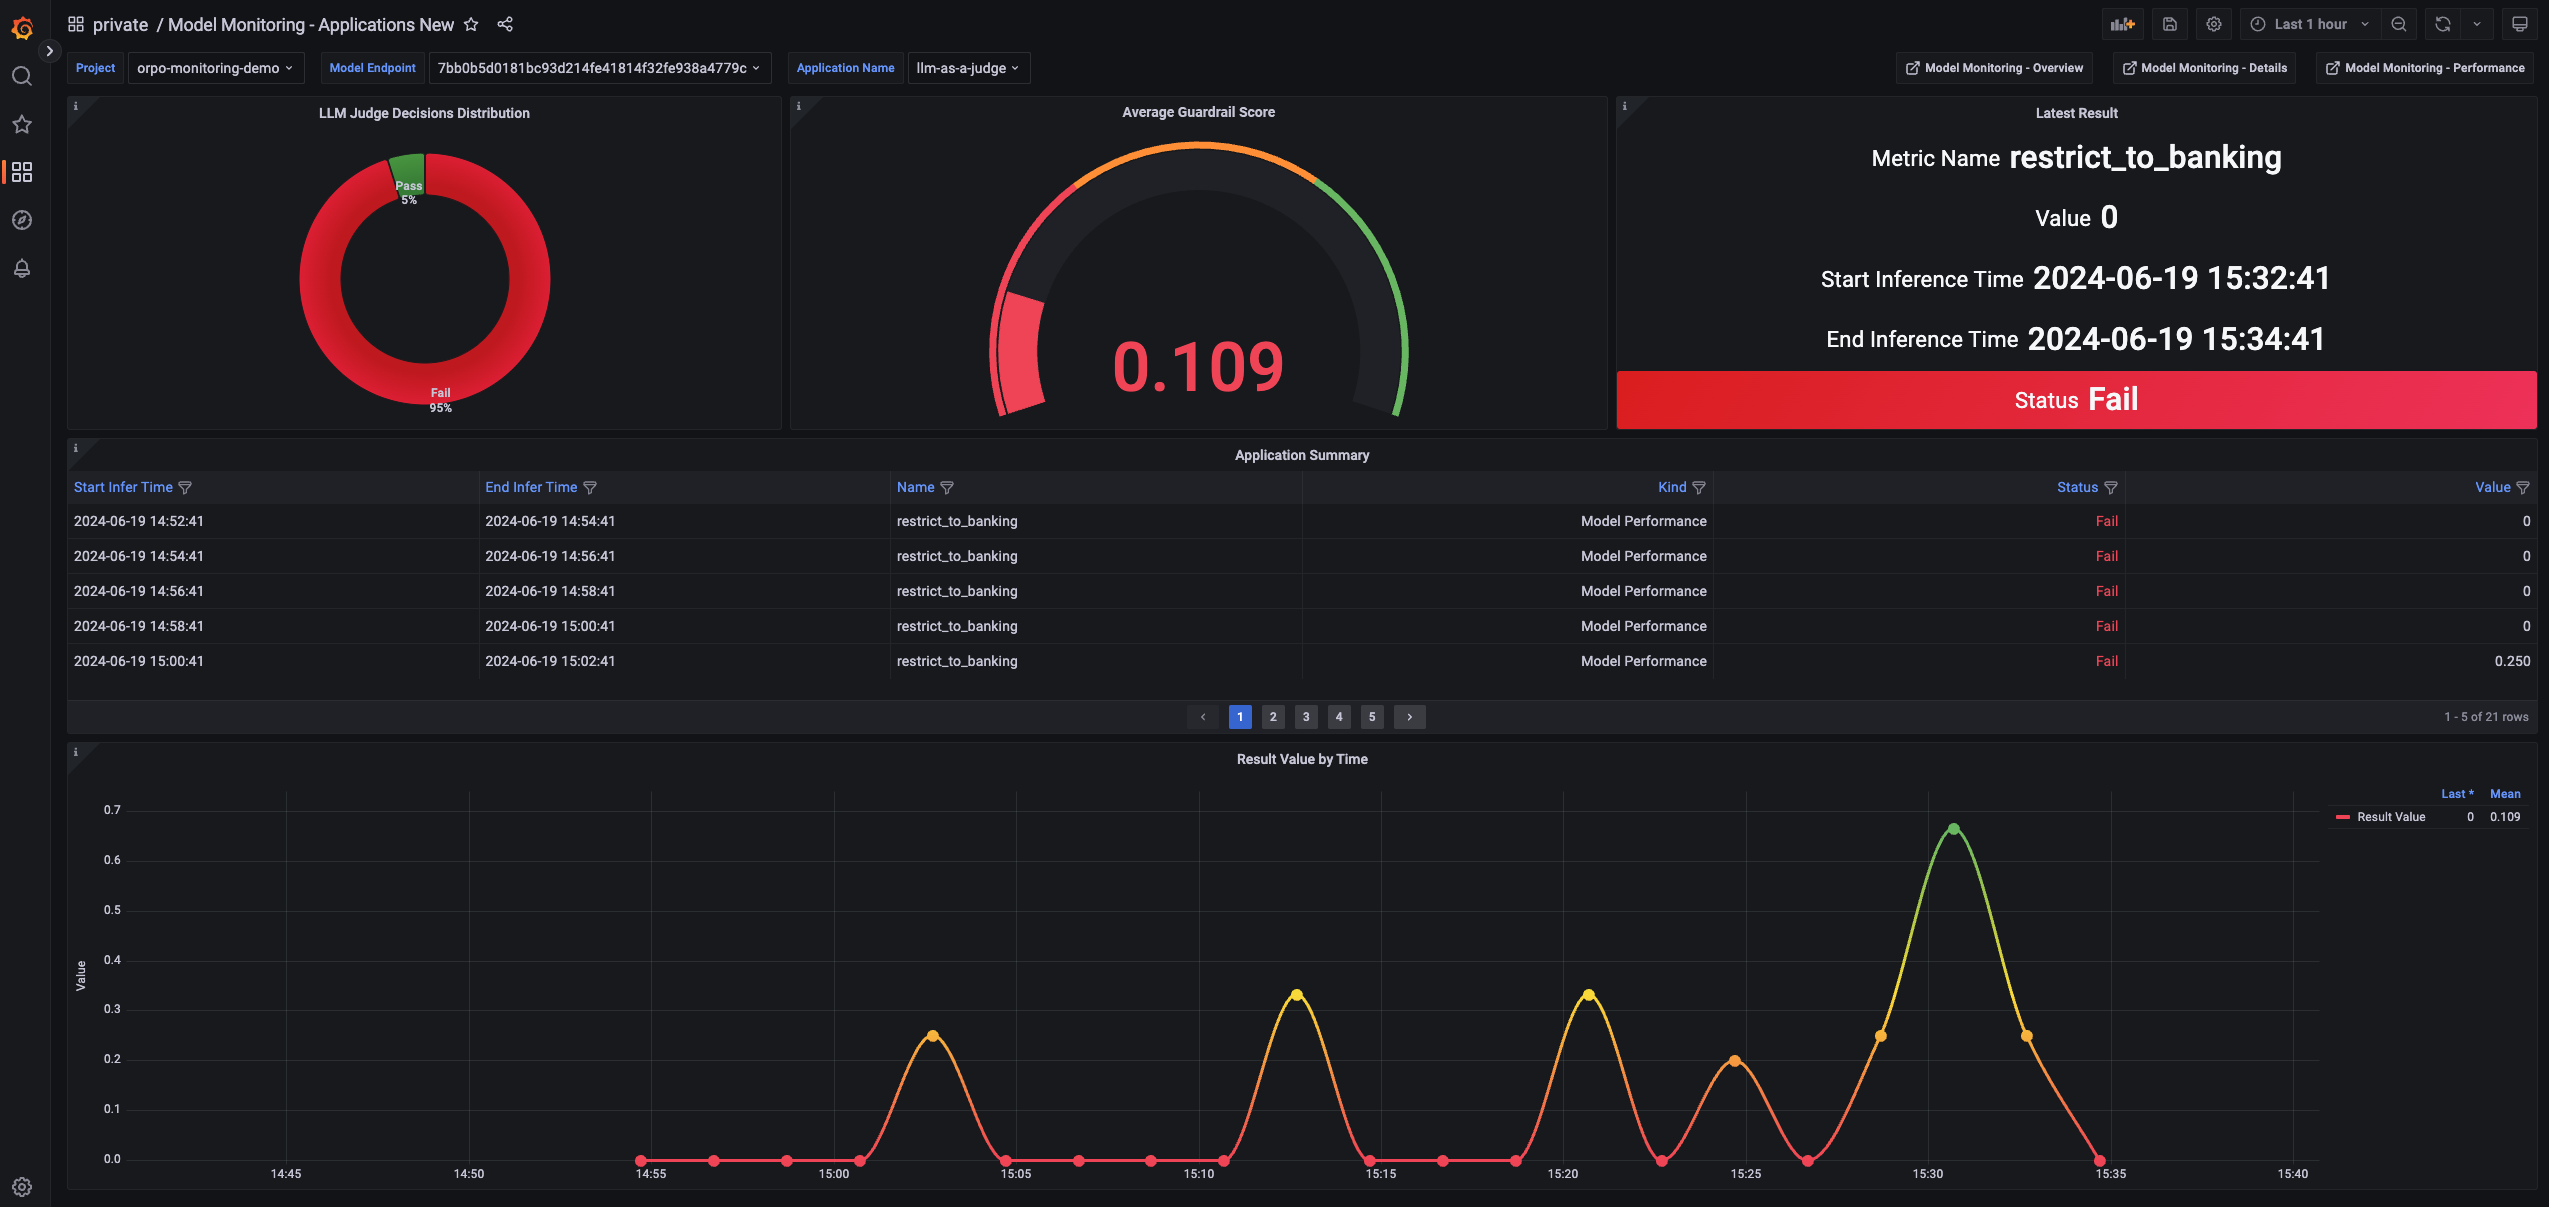

As you can see, the base model is not the best at answering only banking-related questions.

## Build a dataset according to ORPO structure

To fine-tune the model, take the requests sent to the model (questions related to and not related to banking), build a dataset according to the ORPO structure (question, score, chosen, rejected). (Afterwards), and re-train the model with it.

The result in a fine-tuned model that only answers banking-questions.

First fetch the data from the initial traffic to the model:

In [30]:
datasets = project.list_artifacts(kind="dataset")
ds_key = datasets[0]["spec"]["db_key"]
input_ds = f"store://datasets/{project.name}/{ds_key}"

Build the dataset:

In [27]:
ret = project.run_function(
    function="generate-ds",
    handler="generate_ds",
    params={"input_ds": input_ds},
    outputs=["new-train-ds", "dataset"],
)

> 2024-09-16 13:20:48,127 [info] Storing function: {"db":"http://mlrun-api:8080","name":"generate-ds-generate-ds","uid":"c6c242bdb57d4bcc8efdf6213eb3a313"}
> 2024-09-16 13:20:48,396 [info] Job is running in the background, pod: generate-ds-generate-ds-vwnk5
> 2024-09-16 13:25:07,957 [info] OpenAI client created
> 2024-09-16 13:25:07,999 [info] Input dataset fetched
> 2024-09-16 13:32:46,056 [info] score, chosen and rejected populated
> 2024-09-16 13:32:46,119 [info] Dataframe logged
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
> 2024-09-16 13:32:47,223 [info] Dataset uploaded to HF
> 2024-09-16 13:32:47,301 [info] T

project,uid,iter,start,state,kind,name,labels,inputs,parameters,results,artifacts
tutorial,...3eb3a313,0,Sep 16 13:25:07,completed,run,generate-ds-generate-ds,v3io_user=edmondkind=jobowner=edmondmlrun/client_version=1.7.0-rc40mlrun/client_python_version=3.9.18host=generate-ds-generate-ds-vwnk5,,input_ds=store://datasets/tutorial/llm-as-a-judge-logger_restrict_to_banking,dataset=mlrun/banking-orpo-new,new-train-ds


> 2024-09-16 13:32:56,821 [info] Run execution finished: {"name":"generate-ds-generate-ds","status":"completed"}


In [39]:
ret.outputs

{'dataset': 'mlrun/banking-orpo-new',
 'new-train-ds': 'store://artifacts/mm-demo-edmond/generate-ds-generate-ds_new-train-ds:latest@b7dadc94375e41429c9ad913ec26d89c'}

Now we have a new dataset for the model tuning stored in HuggingFace.

## Fine-tuning the model with ORPO 
Now, fine-tune the model using the ORPO algorithm, so that the model only answers the banking-related questions.

[ORPO](https://arxiv.org/abs/2403.07691) is a new method designed to simplify and improve the process of fine-tuning language models to align with user preferences.


In [31]:
project.run_function(
    function="train",
    params={
        "dataset": "mlrun/banking-orpo-opt",
        "base_model": "google/gemma-2b",
        "new_model": "mlrun/gemma-2b-bank-v0.2",
        "device": "cuda:0",
    },
    handler="train",
    outputs=["model"],
)

> 2024-09-17 12:10:33,253 [info] Storing function: {"db":"http://mlrun-api:8080","name":"train-train","uid":"4a01d76a81204ccca98d752b716f4572"}
> 2024-09-17 12:10:33,559 [info] Job is running in the background, pod: train-train-p69gn
Generating train split: 100%|██████████| 786/786 [00:00<00:00, 66040.12 examples/s]
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Map: 100%|██████████| 8/8 [00:00<00:00, 649.65 examples/s]
> 2024-09-17 12:14:58,656 [info] training 'mlrun/gemma-2b-bank-v0.2' based on 'google/gemma-2b'
  0%|          | 0/582 [00:00<?, ?it/s]torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain cu

project,uid,iter,start,state,kind,name,labels,inputs,parameters,results
tutorial,...716f4572,0,Sep 17 12:14:25,completed,run,train-train,v3io_user=edmondkind=jobowner=edmondmlrun/client_version=1.7.0-rc40mlrun/client_python_version=3.9.18host=train-train-p69gn,,dataset=mlrun/banking-orpo-optbase_model=google/gemma-2bnew_model=mlrun/gemma-2b-bank-v0.2device=cuda:0,


> 2024-09-17 12:45:24,293 [info] Run execution finished: {"name":"train-train","status":"completed"}


## Check the performance of the fine-tuned model
Now load and deploy the trained model to see how it performs.

In [7]:
serving_function.add_model(
    base_model,
    class_name="LLMModelServer",
    llm_type="HuggingFace",
    model_name="google/gemma-2b",
    adapter="mlrun/gemma-2b-bank-v0.2",
    model_path=f"store://models/{project.name}/{base_model}:latest",
    generate_kwargs={
        "do_sample": True,
        "top_p": 0.9,
        "num_return_sequences": 1,
        "max_length": 80,
    },
    device_map="cuda:0",
)
serving_function.set_tracking()

In [8]:
deployment = serving_function.deploy()

> 2024-09-17 08:46:00,704 [info] Starting remote function deploy
2024-09-17 08:46:01  (info) Deploying function
2024-09-17 08:46:01  (info) Building
2024-09-17 08:46:02  (info) Staging files and preparing base images
2024-09-17 08:46:02  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-09-17 08:46:02  (info) Building processor image
2024-09-17 08:50:27  (info) Build complete
2024-09-17 08:51:51  (info) Function deploy complete
> 2024-09-17 08:51:55,795 [info] Successfully deployed function: {"external_invocation_urls":["tutorial-llm-server.default-tenant.app.llm-dev.iguazio-cd1.com/"],"internal_invocation_urls":["nuclio-tutorial-llm-server.default-tenant.svc.cluster.local:8080"]}


In [ ]:
while True:
    question_model(
        questions=example_questions,
        serving_function=serving_function,
        base_model=base_model,
    )

The Grafana model monitoring page shows a high pass rate and a high guardrails score:

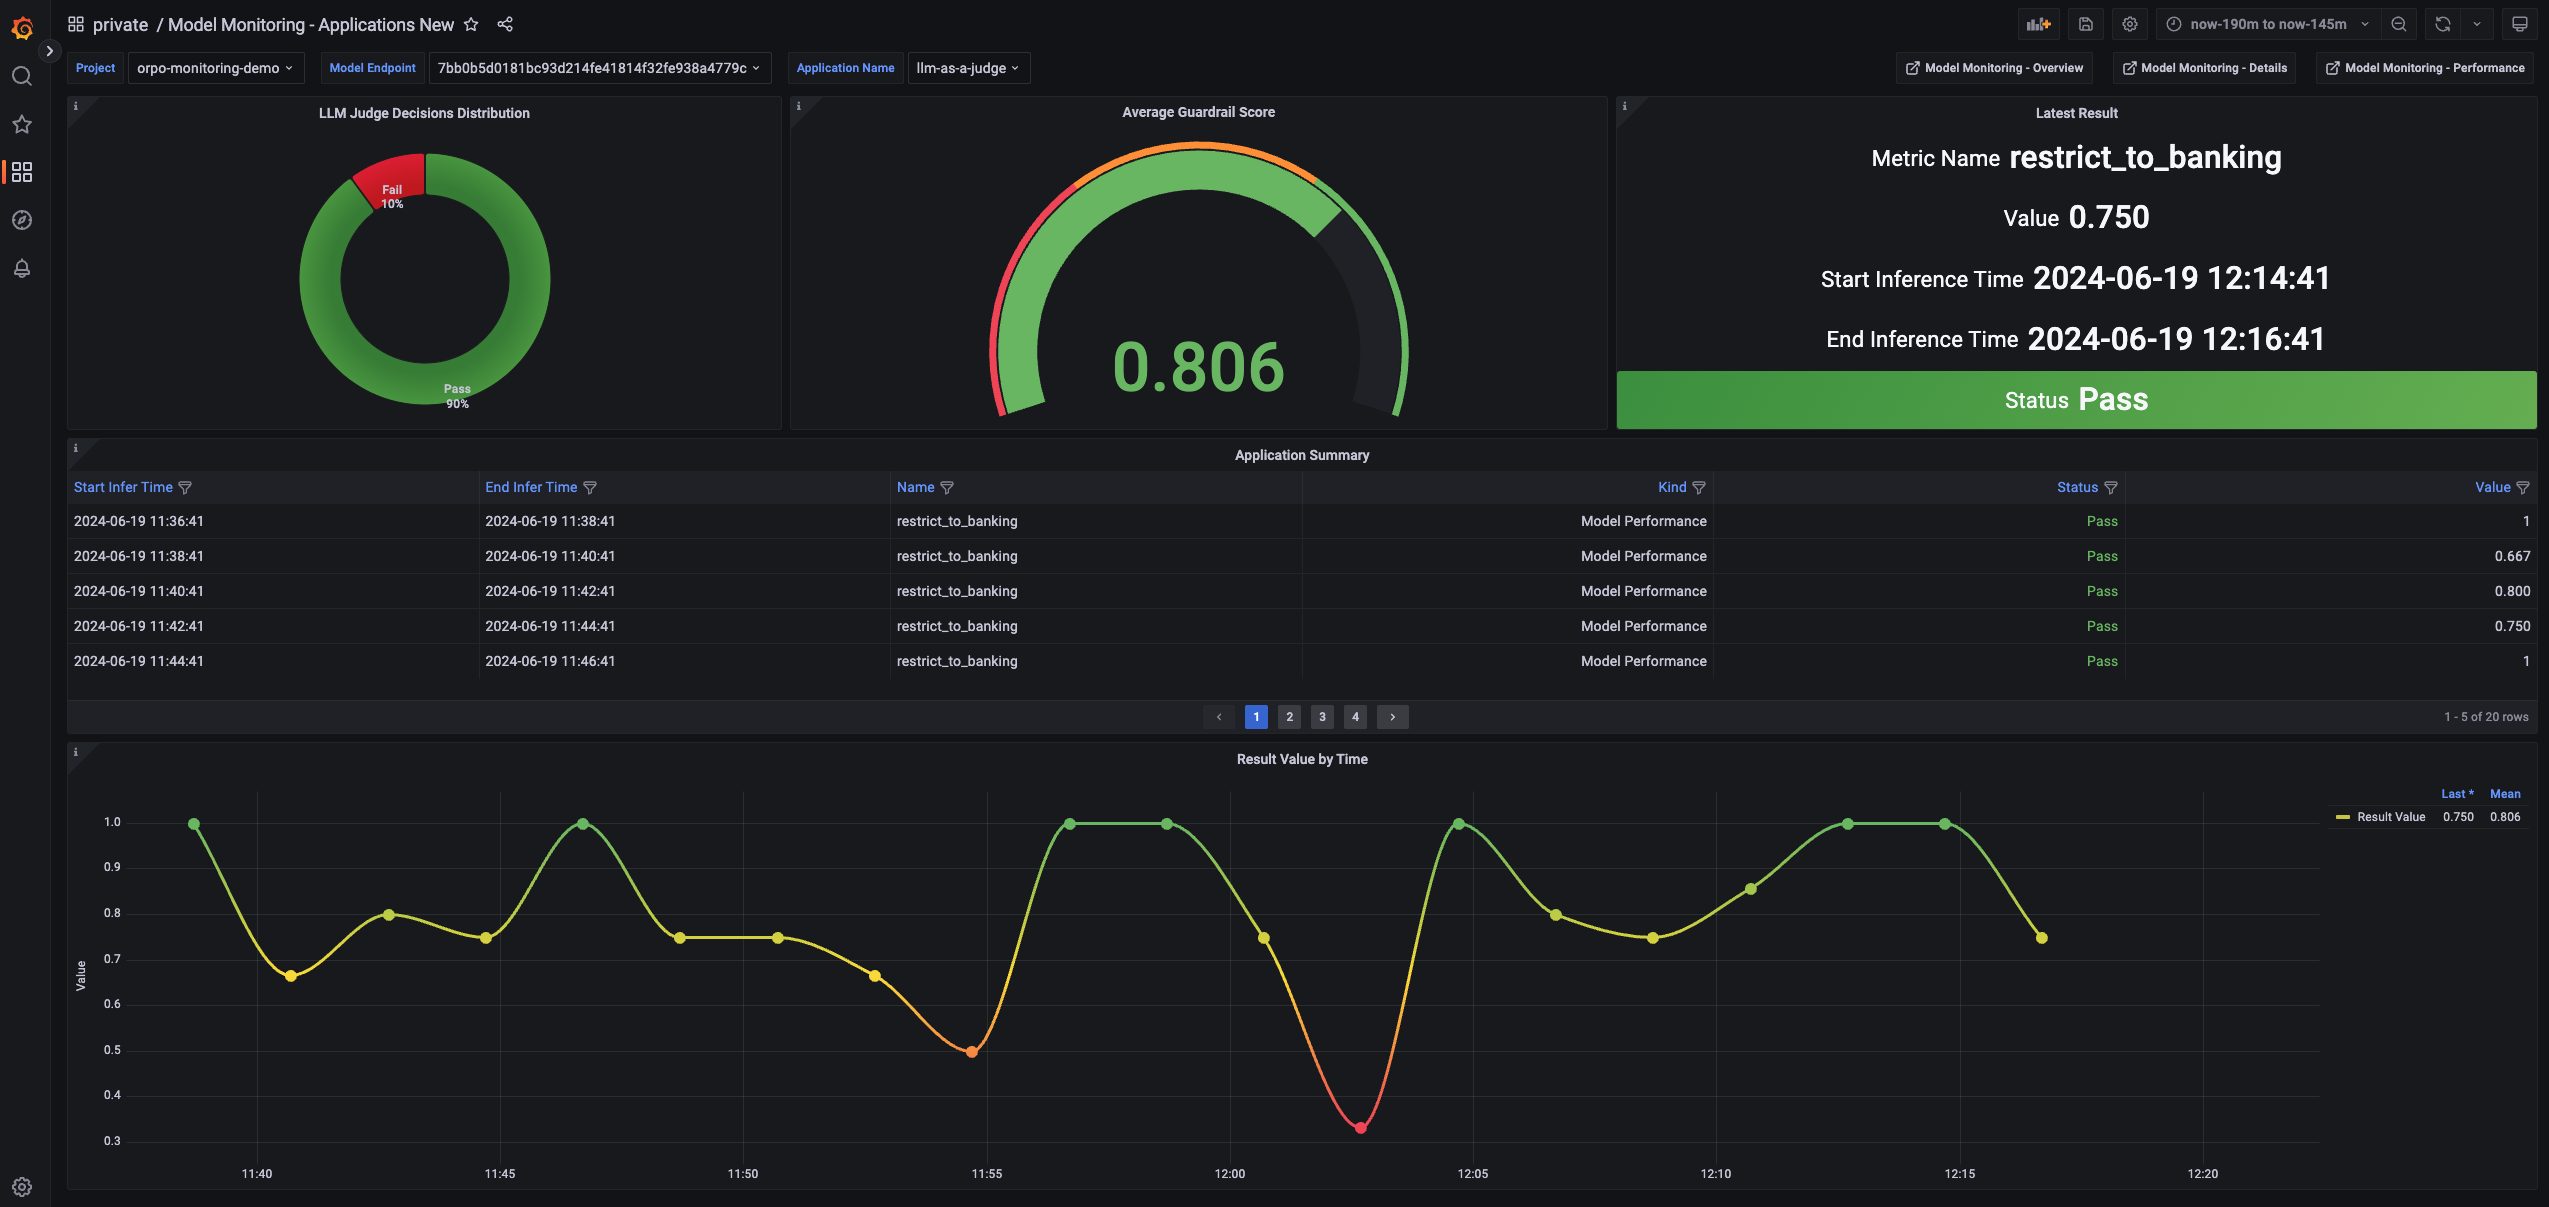

## Build an automated pipeline

The pipeline uses the [`restrict_to_banking` alert](#configure-an-alert) to check for drift. If drift is detected, it triggers retraining of the model (using the ORPO algorithm), and then deploys the improved model.

In [11]:
%%writefile genai_monit_src/workflow.py
import mlrun
from kfp import dsl

    
@dsl.pipeline(
    name="GenAI alerts demo"
)

def kfpipeline(metric_name: str, 
               input_ds):
    
    project = mlrun.get_current_project()
    
    sample = project.run_function(
        function="metric-sample",
        name="metric-sample",
        handler="sample",
        params = {"metric_name" : metric_name},
        outputs=['alert_triggered']
    )

    with dsl.Condition(sample.outputs['alert_triggered'] == "True"):

        # Generate a new DS based on the traffic
        ds = project.run_function(
            function="generate-ds",
            handler="generate_ds",
            params={"input_ds" : input_ds}, 
            outputs=["new-train-ds","dataset"])
        
        # Re-train the new model        
        train = project.run_function(
            function="train",
            params={
                "dataset": "mlrun/banking-orpo-opt",
                "base_model": "google/gemma-2b",
                "new_model": "mlrun/gemma-2b-bank-v0.2",
                "device": "cuda:0"},
            handler="train",
            outputs=["model"],
            ).after(ds)
        
        # Deploy the function with the new (re-trained) model
        deploy = project.get_function('llm-server')
        deploy.add_model(
            "google-gemma-2b",
            class_name="LLMModelServer",
            llm_type="HuggingFace",
            model_name="google/gemma-2b",
            adapter="mlrun/gemma-2b-bank-v0.2", 
            model_path=f"store://models/{project.name}/google-gemma-2b:latest",
            generate_kwargs={
                "do_sample": True,
                "top_p": 0.9,
                "num_return_sequences": 1,
                "max_length": 80,
            },
            device_map="cuda:0",
        )
        deploy.set_tracking()
        project.deploy_function("llm-server").after(train)
        

Writing genai_monit_src/workflow.py


In [12]:
project.set_function(f"db://{project.name}/llm-server")
project.set_function(f"db://{project.name}/train")
project.set_function(f"db://{project.name}/metric-sample")
project.set_function(f"db://{project.name}/generate-ds")
project.set_workflow("main", "workflow.py", embed=True)
project.save()

In [13]:
run_id = project.run(
    "main",
    arguments={"metric_name": "restrict_to_banking alert", "input_ds": input_ds},
    watch=False,
)

> 2024-09-17 08:53:22,670 [info] Pipeline submitted successfully: {"id":"1012b16b-698a-4c7d-b6c3-e11b496a14d1","pipeline_name":"tutorial-main 2024-09-17 08-53-22"}
> 2024-09-17 08:53:22,671 [info] Pipeline run id=1012b16b-698a-4c7d-b6c3-e11b496a14d1, check UI for progress


> 2024-09-17 08:53:22,759 [info] Started run workflow tutorial-main with run id = '1012b16b-698a-4c7d-b6c3-e11b496a14d1' by kfp engine
